In [44]:
from netCDF4 import Dataset, num2date
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point,Polygon

Primeiro, desculpa por qualquer falta de acentuacao ou de cedilhas.
Eu uso um teclado americano e por sanidade nao vou ficar mudando para o teclado br.

In [3]:
grace = Dataset("DATA/GRACE/GRCTellus.CSR.200204_201701.LND.RL05.DSTvSCS1409.nc")
scale = Dataset("DATA/GRACE/CLM4.SCALE_FACTOR.DS.G300KM.RL05.DSTvSCS1409.nc")

In [118]:
scale

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.5
    Institution: JPL / GRACE-TELLUS
    Variable: scaling factor and measurement errors
    Platform: GRACE
    Sensor: GRACE
    Filter_Width_KM: 300
    DATE_CREATED: Wed Feb 19 15:04:06 2014
    dimensions(sizes): Longitude(360), Latitude(180)
    variables(dimensions): float32 Longitude(Longitude), float32 Latitude(Latitude), float32 SCALE_FACTOR(Latitude,Longitude), float32 MEASUREMENT_ERROR(Latitude,Longitude), float32 LEAKAGE_ERROR(Latitude,Longitude)
    groups: 

In [49]:
lwe =grace["lwe_thickness"][0].filled()
lat = grace["lat"][:]
lon = grace["lon"][:]

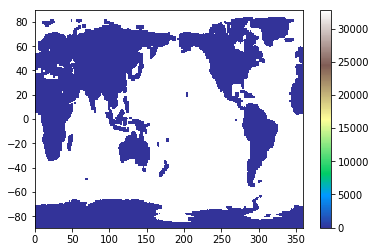

In [14]:
plt.pcolormesh(lon,lat,lwe,cmap="terrain")
plt.colorbar();

In [39]:
shapefile_path = "DATA/cerrado/shape.shp"
cerrado_shp = gpd.read_file(shapefile_path)


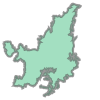

In [40]:
polygon = cerrado_shp.iloc[0]["geometry"]
polygon

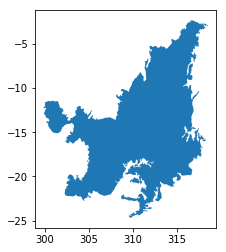

In [47]:
x, y = polygon.exterior.xy
x =360 + np.array(x)

polygon_geom =Polygon(zip(x, y))
new_shp = gpd.GeoDataFrame(index=[0],crs=cerrado_shp.crs,geometry=[polygon_geom])
new_shp.plot()

Aqui podemos ver que as coordenas estao compativeis

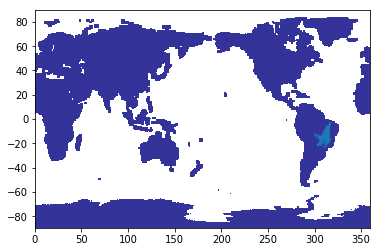

In [51]:
fig,ax = plt.subplots(1,1)

ax.pcolormesh(lon,lat,lwe,cmap="terrain")
new_shp.plot(ax=ax);

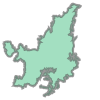

In [54]:
polygon_corr = new_shp.iloc[0]["geometry"]
polygon_corr

In [88]:
# I'll use masked array, so all values marked to True in the masked are considered invalid.
# ergo, all False values in the mask are true
mask = np.full_like(lwe,True,dtype=bool)

for lat_index in range(mask.shape[0]):
    for lon_index in range(mask.shape[1]):
        point = Point(lon[lon_index],lat[lat_index])
        
        if point.within(polygon_corr):
            # all points insinde the polygon are marked to False (in the np masked logic = No invalid)
            mask[lat_index,lon_index] = False

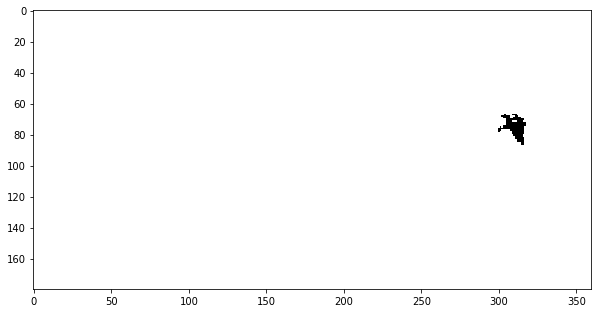

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(mask,cmap="gray");

Pode parecer estar de cabeca pra baixo, e esta, mas os dados do grace tambem estao.

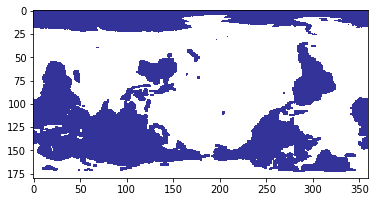

In [91]:
plt.imshow(lwe,cmap="terrain");

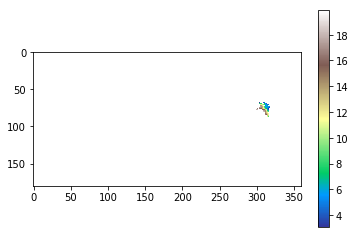

In [93]:
masked_lwe = np.ma.masked_array(lwe,mask)
plt.imshow(masked_lwe,cmap="terrain")
plt.colorbar();

In [110]:
scale_factor = scale["SCALE_FACTOR"][:]
scale_factor.mask = mask
scale_factor

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=32767.0,
  dtype=float32)

Why are you multipling the grace data for this scalar factor?

Due to the sampling and post-processing of GRACE observations, surface mass variations at small spatial scales tend to be attenuated. Therefore, USERS SHOULD MULTIPLY THE GRCTellus LAND DATA BY THE PROVIDED SCALING GRID. The scaling grid is a set of scaling coefficients, one for each 1 degree bin of the land grids, and are intended to restore much of the energy removed by the destriping, gaussian, and degree 60 filters to the land grids. To use these scaling coefficients, the time series at one grid (1 degree bin) location must be multiplied by the scaling factor at the same 1 degree bin position. The netcdf file with gain factors is CLM4.SCALE_FACTOR.DS.G300KM.nc in the netcdf directory , and it must be applied to the GRACE grids in the same directory (an identical grid in ascii format can be found in the ascii directory) .

https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/

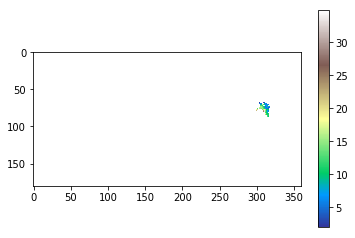

In [113]:
scaled_lwe = masked_lwe * scale_factor


plt.imshow(scaled_lwe,cmap="terrain")
plt.colorbar();